In [2]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/deep_al/results/udal/synthetic results
ls results

resnet18


In [4]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
        # checkpoint = torch.load(exp_checkpoint)
    except:
        print(f'{path} has missing results.')
        return

    results['cfg'] = cfg
    # results['checkpoint'] = checkpoint
    results['results'] = data
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'results/resnet18/random/N_INIT{10}__ACQ_SIZE{10}__N_ACQ{49}/'
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['train_history'][-1].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

dict_keys(['train_history', 'training_time', 'evaluation_time', 'test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['train_lr', 'train_loss', 'train_acc1'])
dict_keys(['test_acc1', 'test_prec', 'test_loss', 'test_nll', 'test_tce', 'test_mce'])


In [5]:
model = 'resnet18'
experiments = {}

experiments.update({
    'random (Deterministic)': f'results/resnet18/random/N_INIT{2}__ACQ_SIZE{2}__N_ACQ{19}/',
    'uncertainty (Deterministic)': f'results/resnet18/uncertainty/N_INIT{2}__ACQ_SIZE{2}__N_ACQ{19}/',
    'aleatoric (Deterministic)': f'results/resnet18/aleatoric/N_INIT{2}__ACQ_SIZE{2}__N_ACQ{19}/',
    'epistemic (Deterministic)': f'results/resnet18/epistemic/N_INIT{2}__ACQ_SIZE{2}__N_ACQ{19}/',
})

all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


100%|██████████| 4/4 [00:00<00:00, 34.14it/s]


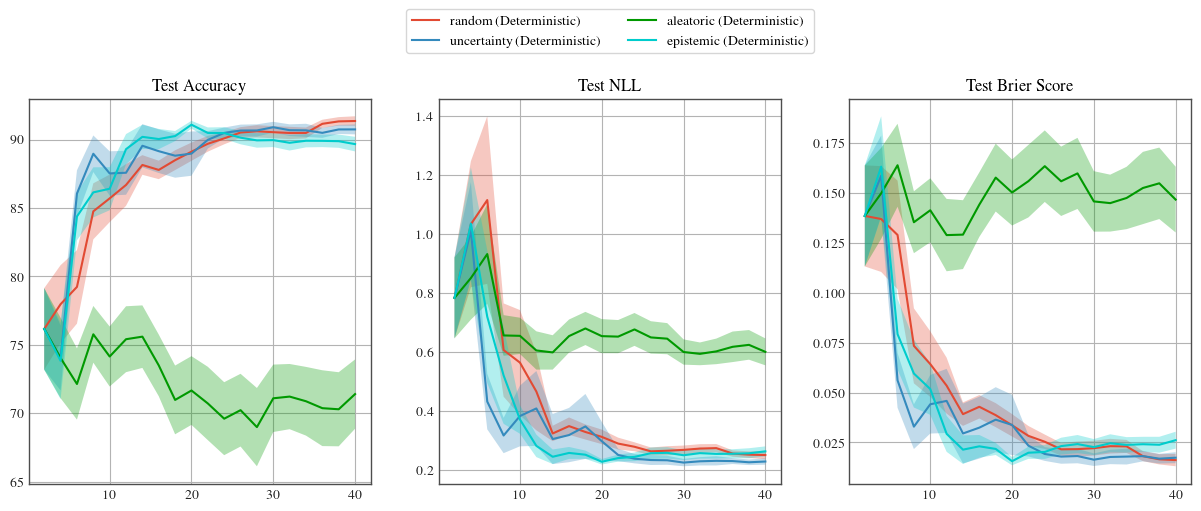

In [8]:
learning_curves = {}
plt.figure(figsize=(15, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []

    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['test_brier'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    factor =  np.sqrt(len(train_accs))
    train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0) / factor
    train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)/ factor
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)/ factor
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)/ factor
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)/ factor

    learning_curves[strat_name] = dict(
        n_labeled_samples=n_labeled_samples,
        test_accs_mean=test_accs_mean,
        test_accs_std=test_accs_std,
        test_brier_mean=test_brier_mean,
        test_brier_std=test_brier_std,
        test_nll_mean=test_nll_mean,
        test_nll_std=test_nll_std,
    )

    plt.subplot(131)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(132)
    plt.title('Test NLL')
    plt.plot(n_labeled_samples, test_nll_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)
    plt.subplot(133)
    plt.title('Test Brier Score')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)

plt.subplot(132).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

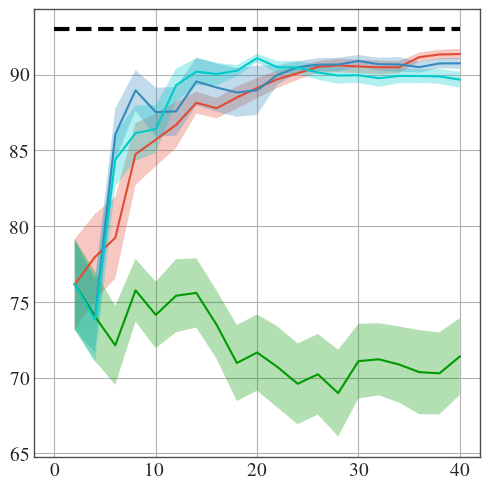

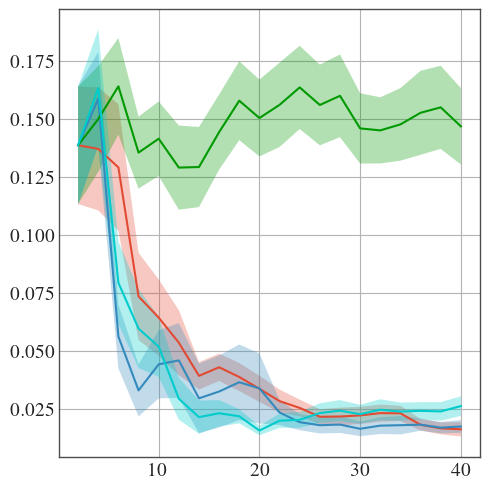

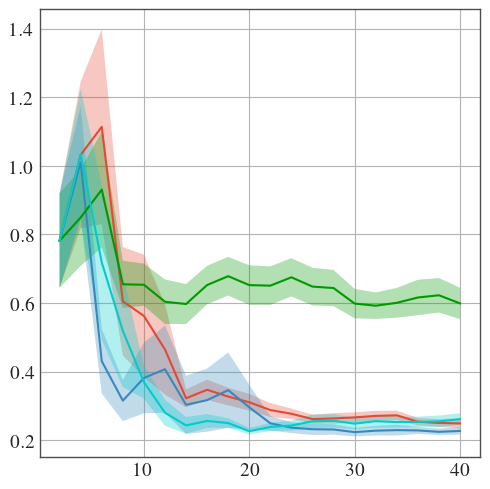

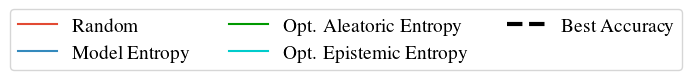

In [9]:
fig = plt.figure(figsize=(5, 5))
n_labeled_samples = learning_curves['random (Deterministic)']['n_labeled_samples']
test_accs_mean= learning_curves['random (Deterministic)']['test_accs_mean']
test_accs_std = learning_curves['random (Deterministic)']['test_accs_std']
plt.plot(n_labeled_samples, test_accs_mean, '-', label='Random', )
plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)

n_labeled_samples = learning_curves['uncertainty (Deterministic)']['n_labeled_samples']
test_accs_mean= learning_curves['uncertainty (Deterministic)']['test_accs_mean']
test_accs_std = learning_curves['uncertainty (Deterministic)']['test_accs_std']
plt.plot(n_labeled_samples, test_accs_mean, '-', label='Entropy')
plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)

n_labeled_samples = learning_curves['aleatoric (Deterministic)']['n_labeled_samples']
test_accs_mean= learning_curves['aleatoric (Deterministic)']['test_accs_mean']
test_accs_std = learning_curves['aleatoric (Deterministic)']['test_accs_std']
plt.plot(n_labeled_samples, test_accs_mean, '-', label='Aleatoric')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)

n_labeled_samples = learning_curves['epistemic (Deterministic)']['n_labeled_samples']
test_accs_mean= learning_curves['epistemic (Deterministic)']['test_accs_mean']
test_accs_std = learning_curves['epistemic (Deterministic)']['test_accs_std']
plt.plot(n_labeled_samples, test_accs_mean, '-', label='Epistemic')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
plt.hlines(93, 0, 40, colors='black', linestyles='--', linewidth=3) # TODO

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, prop={'size': 13})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('./synthetic_images/lc_acc.pdf', bbox_inches='tight', pad_inches=0)

plt.figure(figsize=(5, 5))
n_labeled_samples = learning_curves['random (Deterministic)']['n_labeled_samples']
test_brier_mean= learning_curves['random (Deterministic)']['test_brier_mean']
test_brier_std = learning_curves['random (Deterministic)']['test_brier_std']
plt.plot(n_labeled_samples, test_brier_mean, '-', label='Random', )
plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)

n_labeled_samples = learning_curves['uncertainty (Deterministic)']['n_labeled_samples']
test_brier_mean= learning_curves['uncertainty (Deterministic)']['test_brier_mean']
test_brier_std = learning_curves['uncertainty (Deterministic)']['test_brier_std']
plt.plot(n_labeled_samples, test_brier_mean, '-', label='Entropy')
plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)

n_labeled_samples = learning_curves['aleatoric (Deterministic)']['n_labeled_samples']
test_brier_mean= learning_curves['aleatoric (Deterministic)']['test_brier_mean']
test_brier_std = learning_curves['aleatoric (Deterministic)']['test_brier_std']
plt.plot(n_labeled_samples, test_brier_mean, '-', label='Aleatoric')
plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)

n_labeled_samples = learning_curves['epistemic (Deterministic)']['n_labeled_samples']
test_brier_mean= learning_curves['epistemic (Deterministic)']['test_brier_mean']
test_brier_std = learning_curves['epistemic (Deterministic)']['test_brier_std']
plt.plot(n_labeled_samples, test_brier_mean, '-', label='Epistemic')
plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('./synthetic_images/lc_brier.pdf', bbox_inches='tight', pad_inches=0)

plt.figure(figsize=(5, 5))
n_labeled_samples = learning_curves['random (Deterministic)']['n_labeled_samples']
test_nll_mean= learning_curves['random (Deterministic)']['test_nll_mean']
test_nll_std = learning_curves['random (Deterministic)']['test_nll_std']
plt.plot(n_labeled_samples, test_nll_mean, '-', label='Random', )
plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)

n_labeled_samples = learning_curves['uncertainty (Deterministic)']['n_labeled_samples']
test_nll_mean= learning_curves['uncertainty (Deterministic)']['test_nll_mean']
test_nll_std = learning_curves['uncertainty (Deterministic)']['test_nll_std']
plt.plot(n_labeled_samples, test_nll_mean, '-', label='Entropy')
plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)

n_labeled_samples = learning_curves['aleatoric (Deterministic)']['n_labeled_samples']
test_nll_mean= learning_curves['aleatoric (Deterministic)']['test_nll_mean']
test_nll_std = learning_curves['aleatoric (Deterministic)']['test_nll_std']
plt.plot(n_labeled_samples, test_nll_mean, '-', label='Aleatoric')
plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)

n_labeled_samples = learning_curves['epistemic (Deterministic)']['n_labeled_samples']
test_nll_mean= learning_curves['epistemic (Deterministic)']['test_nll_mean']
test_nll_std = learning_curves['epistemic (Deterministic)']['test_nll_std']
plt.plot(n_labeled_samples, test_nll_mean, '-', label='Aleatoric')
plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, prop={'size': 13})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('./synthetic_images/lc_nll.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

fig = plt.figure()
plt.plot([], [], '-', label='Random')
plt.plot([], [], '-', label='Model Entropy')
plt.plot([], [], '-', label='Opt. Aleatoric Entropy')
plt.plot([], [], '-', label='Opt. Epistemic Entropy')
plt.hlines(93, 0, 40, colors='black', linestyles='--', linewidth=3, label='Best Accuracy')
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=3,  prop=dict(size=14))
# cax = plt.axes([0.1, 1, .8, .02])
plt.tight_layout()
plt.savefig('synthetic_images/legend.pdf', bbox_inches='tight', pad_inches=0) 
plt.show()